## Imports

In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from geopy.distance import geodesic
import collections
import scipy
import community
from sklearn.mixture import GMM


%matplotlib inline

## Loading the datasets

In [3]:
routes = pd.read_csv('routes.dat', header=None)

routes.columns = ['Airline','Airline ID',
                'Source airport',
                'Source airport ID',
                'Destination airport',
                'Destination airport ID',
                'Codeshare',
                'Stops',
                'Equipment']

In [4]:
routes.head()

Airline Airline ID Source airport Source airport ID Destination airport  \
0      2B        410            AER              2965                 KZN   
1      2B        410            ASF              2966                 KZN   
2      2B        410            ASF              2966                 MRV   
3      2B        410            CEK              2968                 KZN   
4      2B        410            CEK              2968                 OVB   

  Destination airport ID Codeshare  Stops Equipment  
0                   2990       NaN      0       CR2  
1                   2990       NaN      0       CR2  
2                   2962       NaN      0       CR2  
3                   2990       NaN      0       CR2  
4                   4078       NaN      0       CR2

In [5]:
airports = pd.read_csv(
    'airports.dat',
    header=None,
    index_col=4,
    na_values='\\N')
airports.columns = ['Airport ID',
                    'Name',
                    'City',
                    'Country',
                    'ICAO',
                    'Latitude',
                    'Longitude',
                    'Altitude',
                    'Timezone',
                    'DST',
                    'TZ',
                    'Type',
                    'Source']

In [6]:
airports.head()

Airport ID                                         Name          City  \
4                                                                            
GKA           1                               Goroka Airport        Goroka   
MAG           2                               Madang Airport        Madang   
HGU           3                 Mount Hagen Kagamuga Airport   Mount Hagen   
LAE           4                               Nadzab Airport        Nadzab   
POM           5  Port Moresby Jacksons International Airport  Port Moresby   

              Country  ICAO  Latitude   Longitude  Altitude  Timezone DST  \
4                                                                           
GKA  Papua New Guinea  AYGA -6.081690  145.391998      5282      10.0   U   
MAG  Papua New Guinea  AYMD -5.207080  145.789001        20      10.0   U   
HGU  Papua New Guinea  AYMH -5.826790  144.296005      5388      10.0   U   
LAE  Papua New Guinea  AYNZ -6.569803  146.725977       239      10.0   U   
POM  Papua New Guinea  AYPY -9.443380  147.220001       146      10.0   U   

                       TZ     Type       Source  
4                                                
GKA  Pacific/Port_Moresby  airport  OurAirports  
MAG  Pacific/Port_Moresby  airport  OurAirports  
HGU  Pacific/Port_Moresby  airport  OurAirports  
LAE  Pacific/Port_Moresby  airport  OurAirports  
POM  Pacific/Port_Moresby  airport  OurAirports

## Cleaning

In [10]:
airports_route = list(set(set(routes['Source airport']) | set(routes['Destination airport'])))

In [11]:
airports_air = list(airports.index)

In [12]:
nodes = list(set(airports_air) & set(airports_route))

In [13]:
routes_clean = routes[(routes['Source airport'].isin(nodes)) & (routes['Destination airport'].isin(nodes))]

In [14]:
airports_clean = airports[airports.index.isin(nodes)]

In [15]:
routes_clean['Source latitude'] = routes_clean.apply(lambda row : airports_clean[airports_clean['Airport ID'] == int(row['Source airport ID'])].Latitude.values.item(0), axis = 1)
routes_clean['Source longitude'] = routes_clean.apply(lambda row : airports_clean[airports_clean['Airport ID'] == int(row['Source airport ID'])].Longitude.values.item(0), axis = 1)
routes_clean['Destination latitude'] = routes_clean.apply(lambda row : airports_clean[airports_clean['Airport ID'] == int(row['Destination airport ID'])].Latitude.values.item(0), axis = 1)
routes_clean['Destination longitude'] = routes_clean.apply(lambda row : airports_clean[airports_clean['Airport ID'] == int(row['Destination airport ID'])].Longitude.values.item(0), axis = 1)

/home/adirlou/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/adirlou/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/adirlou/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

In [17]:
routes_clean['Distance'] = routes_clean.apply(lambda row : geodesic((row['Source latitude'], row['Source longitude']), (row['Destination latitude'], row['Destination longitude'])).kilometers, axis = 1)

/home/adirlou/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [18]:
routes_clean.head()

Airline Airline ID Source airport Source airport ID Destination airport  \
0      2B        410            AER              2965                 KZN   
1      2B        410            ASF              2966                 KZN   
2      2B        410            ASF              2966                 MRV   
3      2B        410            CEK              2968                 KZN   
4      2B        410            CEK              2968                 OVB   

  Destination airport ID Codeshare  Stops Equipment  Source latitude  \
0                   2990       NaN      0       CR2        43.449902   
1                   2990       NaN      0       CR2        46.283298   
2                   2962       NaN      0       CR2        46.283298   
3                   2990       NaN      0       CR2        55.305801   
4                   4078       NaN      0       CR2        55.305801   

   Source longitude  Destination latitude  Destination longitude     Distance  
0         39.956600             55.606201              49.278702  1507.989717  
1         48.006302             55.606201              49.278702  1040.943207  
2         48.006302             44.225101              43.081902   449.036664  
3         61.503300             55.606201              49.278702   773.126239  
4         61.503300             55.012600              82.650703  1343.161122

**Save the clean data**

In [19]:
routes_clean.to_csv('routes_clean.csv', index=False)
airports_clean.to_csv('airports_clean.csv')

## World map

**Load clean data**

In [2]:
routes = pd.read_csv('routes_clean.csv', low_memory=False)

In [3]:
airports = pd.read_csv('airports_clean.csv', index_col=0)

**Get edges from routes and create graph**

In [4]:
G = nx.from_pandas_edgelist(routes, 'Source airport', 'Destination airport', ['Distance'])

/home/adirlou/.local/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


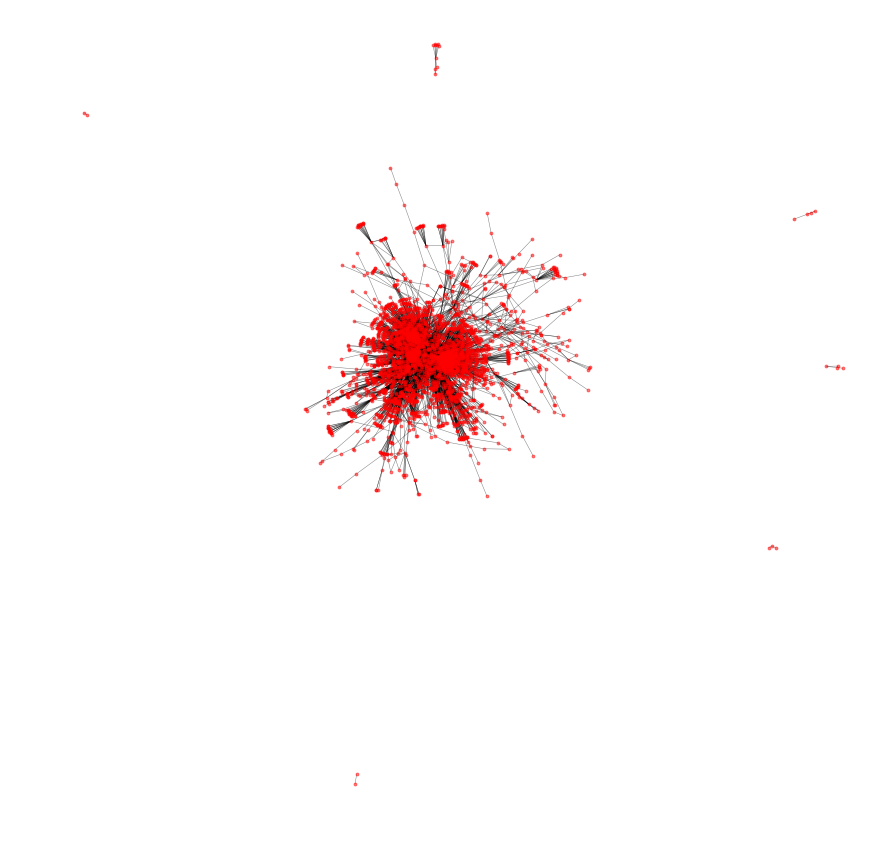

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
nx.draw_networkx(G, ax=ax, node_size=8, alpha=.5,
                 width=.5, with_labels=False)
ax.set_axis_off()

Get largest connected component for the rest

In [5]:
largest_cc = max(nx.connected_component_subgraphs(G), key=len)

To create the map, we first retrieve the coordinates from the airports dataframe

In [150]:
pos = {airport: (v['Longitude'], v['Latitude'])
       for airport, v in
       airports.to_dict('index').items()}

Node size will be the degree of the nodes

In [7]:
deg = nx.degree(largest_cc)
sizes = [5 * deg[iata] for iata in largest_cc.nodes]

Display label only if degree is quite big

In [8]:
labels = {iata: iata if deg[iata] >= 200 else ''
          for iata in largest_cc.nodes}

In [9]:
def display_map(graph, node_color=None):
    # Map projection
    fig, ax = plt.subplots(
        1, 1, figsize=(36, 24),
        subplot_kw=dict(projection=ccrs.PlateCarree()))
    ax.coastlines()

    # Extent of continental US.
    #ax.set_extent([-128, -62, 20, 50])
    nx.draw_networkx(graph, ax=ax,
                     font_size=20,
                     alpha=.5,
                     width=.075,
                     node_size=sizes,
                     labels=labels,
                     pos=pos,
                     node_color=node_color)

/home/adirlou/.local/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


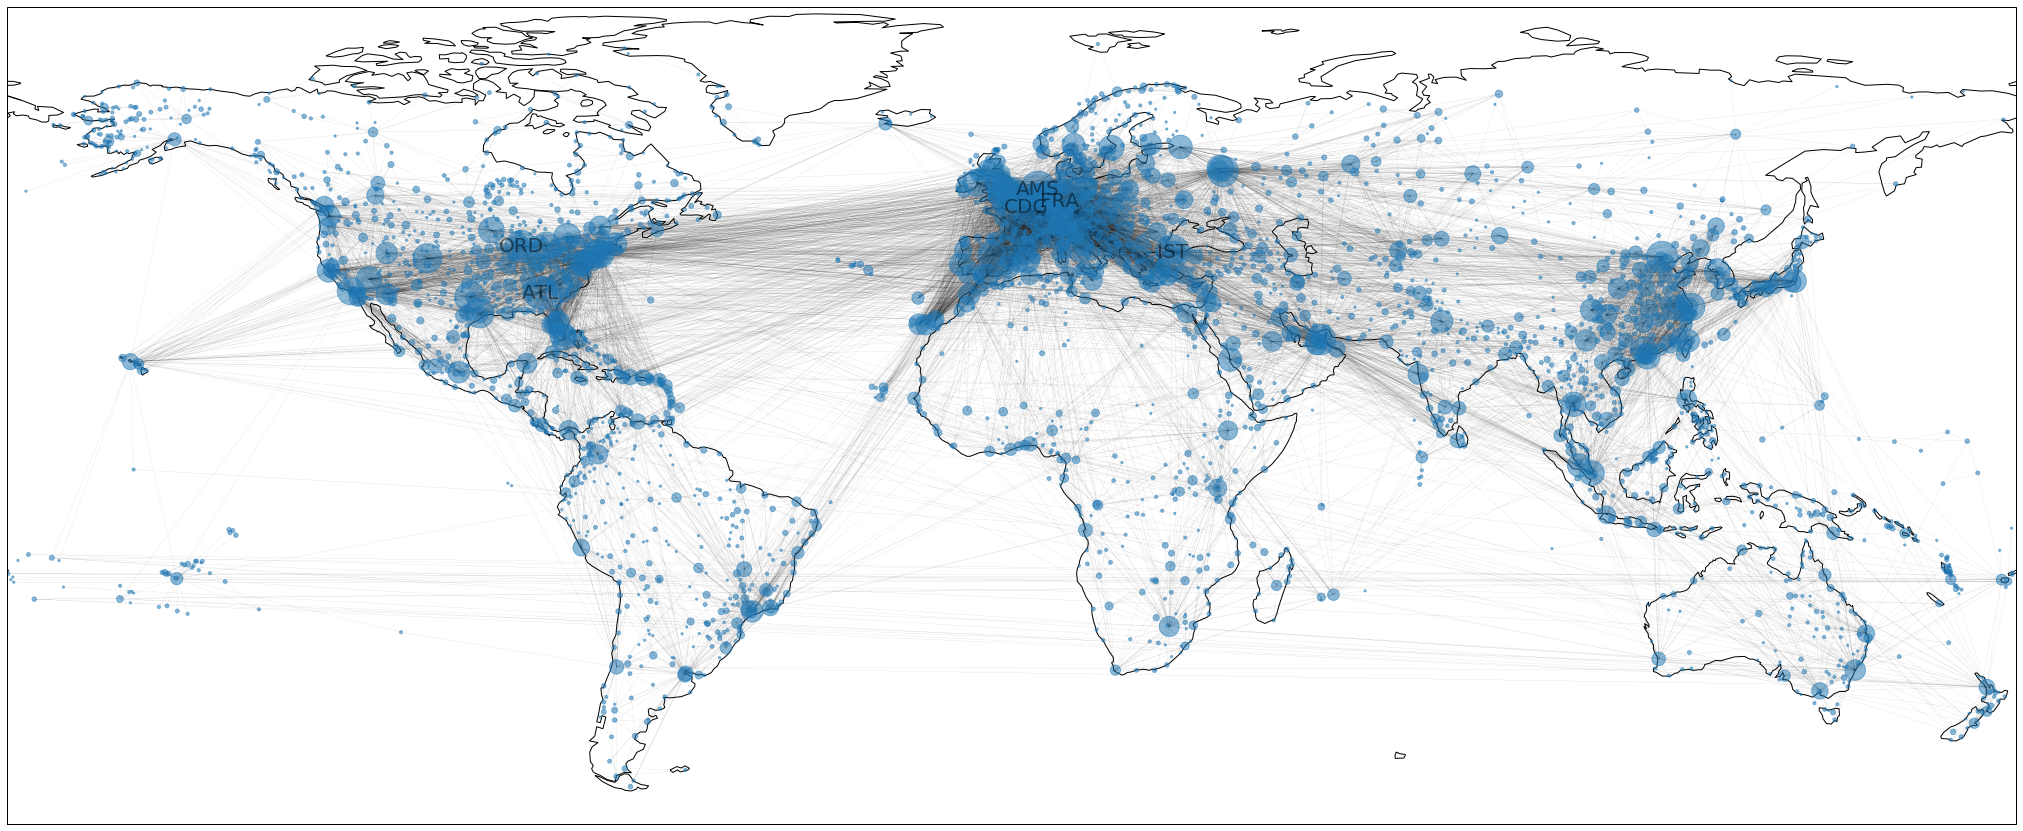

In [89]:
display_map(largest_cc)

## Flight distance

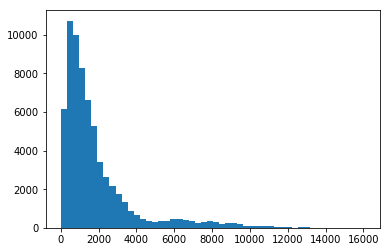

In [32]:
plt.hist(routes_clean['Distance'].values, bins = 50)
plt.show()

## Local/international flights

In [28]:
routes_clean['Source country'] = routes_clean.apply(lambda row : airports_clean[airports_clean['Airport ID'] == int(row['Source airport ID'])].Country.values.item(0), axis = 1)
routes_clean['Destination country'] = routes_clean.apply(lambda row : airports_clean[airports_clean['Airport ID'] == int(row['Destination airport ID'])].Country.values.item(0), axis = 1)

In [29]:
routes_clean['International flight'] = routes_clean.apply(lambda row : not (row['Source country'] == row['Destination country']), axis = 1)

In [30]:
routes_clean['International flight'].value_counts()

True     34222
False    31845
Name: International flight, dtype: int64

In [31]:
collections.Counter(routes_clean['Source country']).most_common(10)

[('United States', 12999),
 ('China', 7995),
 ('United Kingdom', 2634),
 ('Spain', 2525),
 ('Germany', 2328),
 ('France', 1924),
 ('Canada', 1835),
 ('Russia', 1793),
 ('Italy', 1770),
 ('Brazil', 1385)]

In [32]:
collections.Counter(routes_clean['Destination country']).most_common(10)

[('United States', 12994),
 ('China', 7995),
 ('United Kingdom', 2608),
 ('Spain', 2527),
 ('Germany', 2312),
 ('France', 1920),
 ('Canada', 1844),
 ('Russia', 1800),
 ('Italy', 1773),
 ('Brazil', 1382)]

In [33]:
collections.Counter(routes_clean['Source airport']).most_common(10)

[('ATL', 915),
 ('ORD', 556),
 ('CDG', 523),
 ('LHR', 523),
 ('PEK', 520),
 ('LAX', 489),
 ('FRA', 489),
 ('DFW', 469),
 ('JFK', 454),
 ('AMS', 450)]

In [34]:
collections.Counter(routes_clean['Destination airport']).most_common(10)

[('ATL', 911),
 ('ORD', 548),
 ('LHR', 520),
 ('PEK', 519),
 ('CDG', 516),
 ('LAX', 497),
 ('FRA', 485),
 ('DFW', 467),
 ('JFK', 453),
 ('AMS', 446)]

In [35]:
routes_clean[['Source airport', 'Source airport ID', 'Source country']].groupby(['Source airport', 'Source country']).count().sort_values(by = ['Source airport ID'], ascending = False)

Source airport ID
Source airport Source country                         
ATL            United States                       915
ORD            United States                       556
LHR            United Kingdom                      523
CDG            France                              523
PEK            China                               520
LAX            United States                       489
FRA            Germany                             489
DFW            United States                       469
JFK            United States                       454
AMS            Netherlands                         450
PVG            China                               404
SIN            Singapore                           404
BCN            Spain                               389
MIA            United States                       368
ICN            South Korea                         366
MUC            Germany                             363
DEN            United States                       359
LGW            United Kingdom                      352
HKG            Hong Kong                           351
IST            Turkey                              350
DXB            United Arab Emirates                346
FCO            Italy                               329
MAD            Spain                               327
CAN            China                               327
BKK            Thailand                            324
YYZ            Canada                              319
DME            Russia                              319
BRU            Belgium                             314
CTU            China                               312
MAN            United Kingdom                      310
...                                                ...
SLM            Spain                                 1
SFL            Cape Verde                            1
SDY            United States                         1
RRG            Mauritius                             1
GAO            Cuba                                  1
RRS            Norway                                1
RSA            Argentina                             1
GDV            United States                         1
RTA            Fiji                                  1
GDE            Ethiopia                              1
GCN            United States                         1
RUA            Uganda                                1
GBB            Azerbaijan                            1
RUS            Solomon Islands                       1
RUT            United States                         1
RVD            Brazil                                1
SAB            Netherlands Antilles                  1
FJR            United Arab Emirates                  1
FUT            Wallis and Futuna                     1
FUN            Tuvalu                                1
FRD            United States                         1
SCK            United States                         1
FOE            United States                         1
SCM            United States                         1
FMA            Argentina                             1
FLS            Australia                             1
SCZ            Solomon Islands                       1
SDE            Argentina                             1
SDG            Iran                                  1
LUO            Angola                                1

[3164 rows x 1 columns]

## Finding communities with Spectral Clustering

In order to perform spectral clustering on our graph, we will first need to compute the laplacian of our graph:

In [155]:
laplacian = nx.laplacian_matrix(largest_cc)
laplacian = laplacian.asfptype()

We will now compute an embedding of our graph, in order to visualize it in 2 dimensions and also to use a representation in higher dimension, for the clustering.

We define a function below to compute such an embedding. As seen in class, we will compute an eigendecomposition of the laplacian, in an efficient way. That is, if we choose to embed in $k$ dimensions, we will only need to compute the first $k$ eigenvectors.

In [173]:
def compute_embedding(laplacian, dim):
    """Given a graph laplacian and a target dimension, this function
    computes a graph embedding in the chosen dimension. There is the
    option to normalize the eigenvectors in the process."""
    
    #Compute the k first eigenvectors (k depends on the target dimension)
    k_eigenvalues, k_eigenvectors = scipy.sparse.linalg.eigsh(laplacian, k=1+dim, which='SA')        

    #Compute the embedding for each node
    embedding = np.zeros((3154, dim))
    for i in range(3154):
        for k_th in range(dim): 
            embedding[i, k_th] = k_eigenvectors[i, 1+k_th]
            
    return embedding



We decided to compute an embedding in 4 dimensions:

In [180]:
embedding = compute_embedding(laplacian, 4)

Here, we show a graph for a 2D embedding, to have a visualization of the communities in our graph:

In [158]:
# Laplacian eigenmaps (coordinates in 2D)
coords = embedding[:, 0:2]

def plot_signal(signal):
    """Display nodes of the graph in 2D
    together with the given signal"""
    
    nodes = nx.draw_networkx_nodes(largest_cc, dict(zip(largest_cc.nodes, coords)), node_size=30, node_color=signal)
    plt.xlabel('Value of $\lambda_1$')
    plt.ylabel('Value of $\lambda_2$')
    plt.colorbar(nodes)



We plot here the 2D embedding of our graph, together with the first eigenvectors (the Fourier basis) as signals. This way, we hope to see how the graph could be clustered.

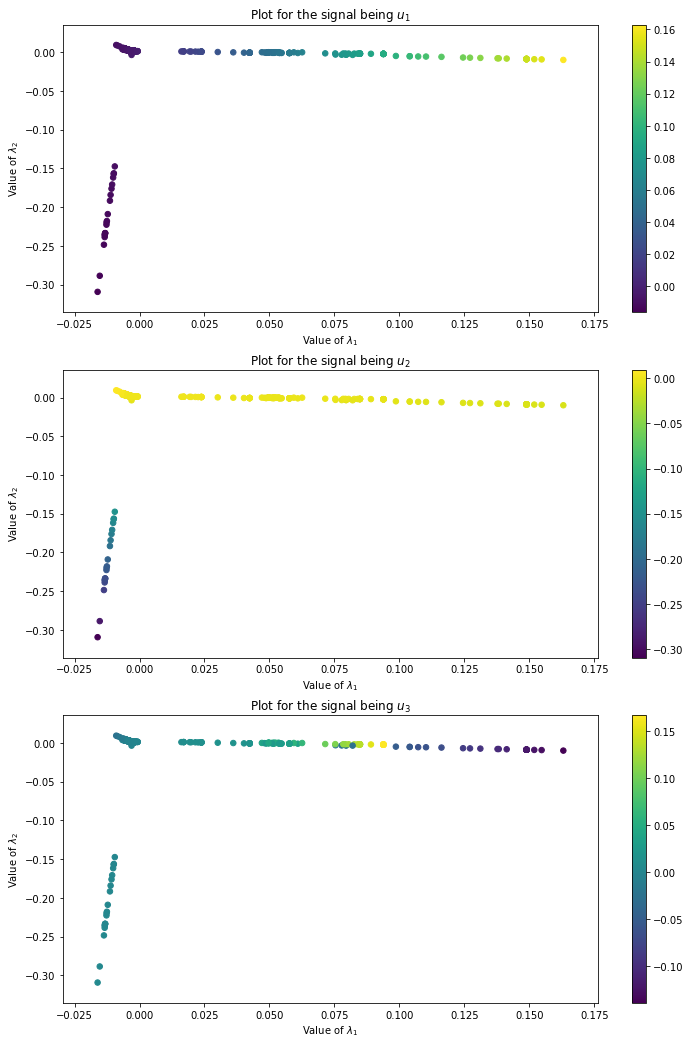

In [159]:
plt.figure(figsize=(12, 18))

# Plot the first 3 Fourier basis vectors
for i in range(3):
    plt.subplot(311 + i)
    plot_signal(embedding[:, i])
    plt.title('Plot for the signal being $u_{'+ str(1 + i)+'}$')

plt.show()



From there, we see that there are 3 blobs of points, which may suggest 3 communities. Moreover, the values of the signals change in a certain way that also suggest 2 or more clusters. 
So it seems that with this method, we won't be able to discover the continents just from the graph. 

Still in the next part, we compute a clustering with 3 clusters, as suggested before, in order to then visualize the cluster on the world map, to maybe see some of the continents as communities.

In order to really compute a clustering, we will use a Gaussian Mixture modelwith the EM algorithm.
Using the GMM model will allow us to have clusters that are non-spherical. We perform the clustering on the embedding of dimension 4.

In [160]:
predictions_gmm = GMM(n_components=3, covariance_type='full').fit_predict(embedding)

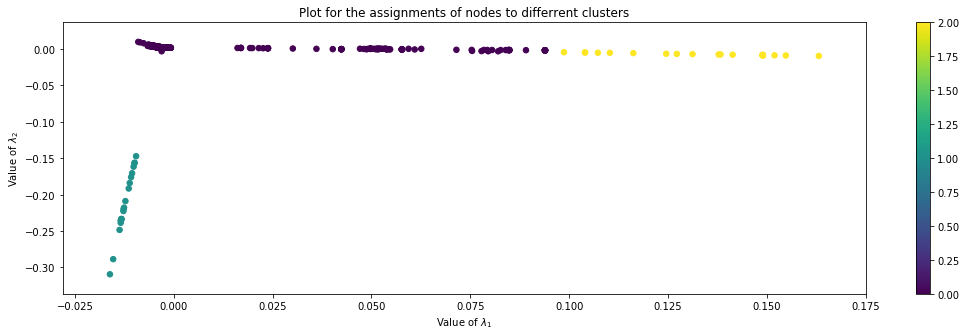

In [161]:
plt.figure(figsize=(18, 5))

plot_signal(predictions_gmm)
plt.title('Plot for the assignments of nodes to differrent clusters')

plt.show()

We now visualize thos 3 clusters directly on the world map:

/home/adirlou/.local/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


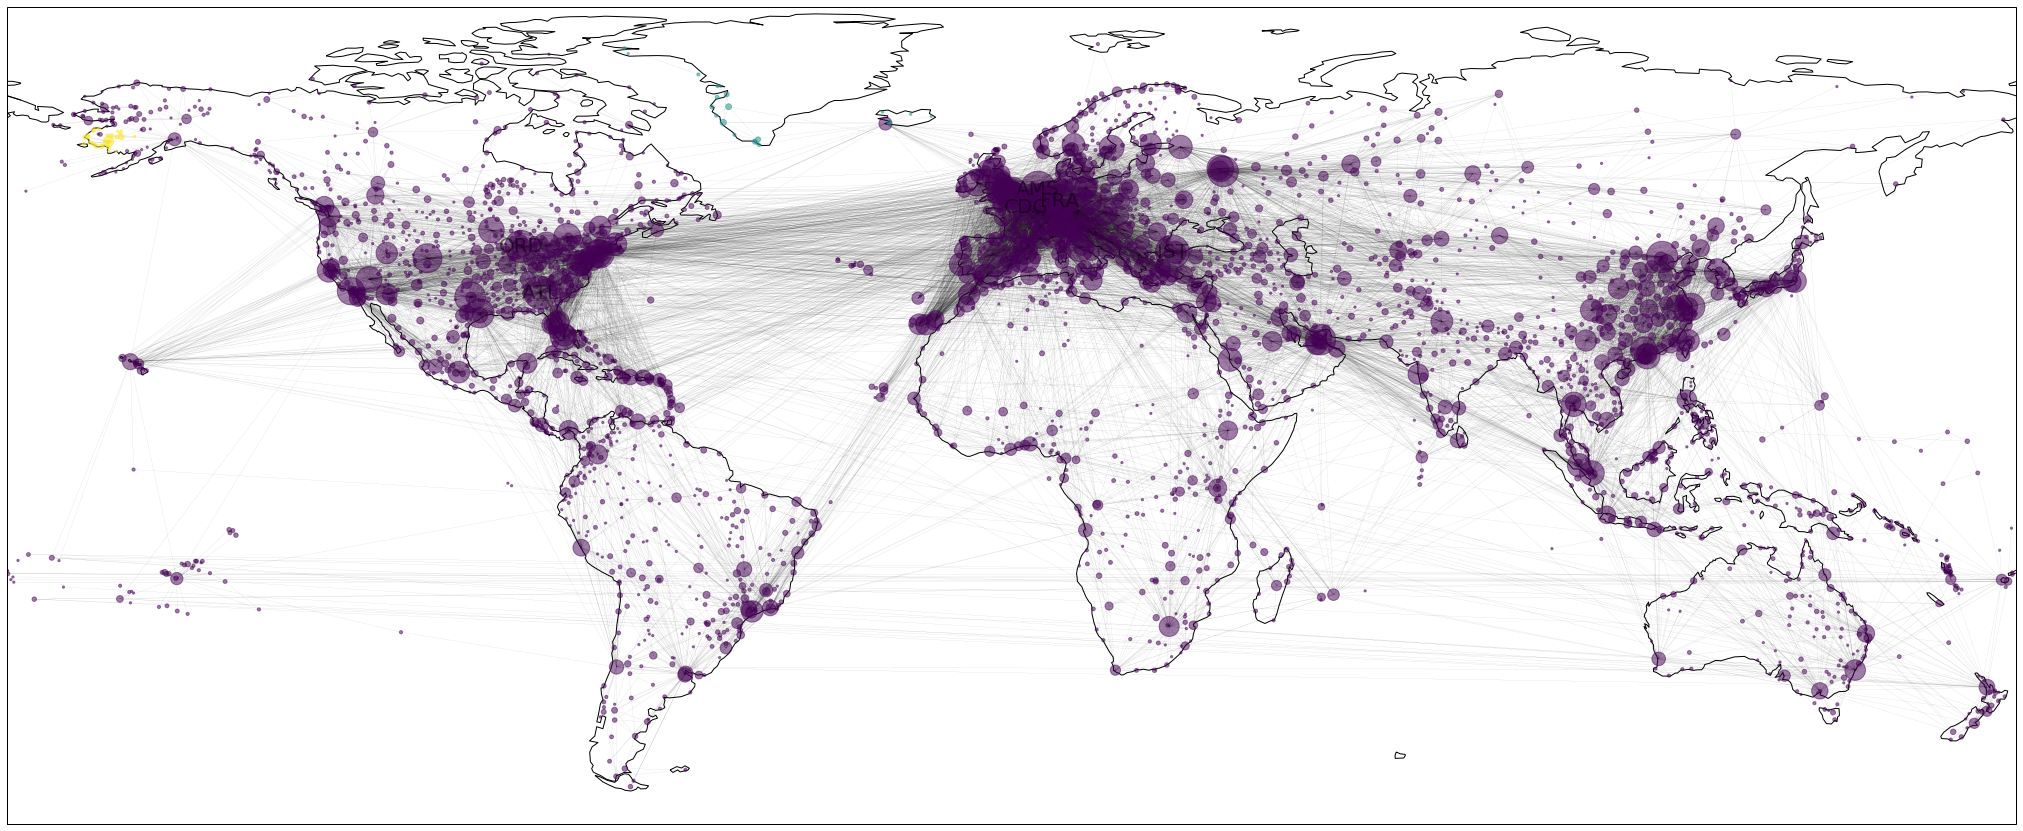

In [162]:
display_map(largest_cc, predictions_gmm)

So we see there that when using spectral clustering, it consider most of the graph as one community. We can actually see a small community in Greenland, and another one in Alaska. It is the case since those airports are almost not connected to the rest of the world, forming a community of their own.

Actually, by also computing the full eigendecomposition, and plotting the eigenvalues index against their actual value, we see the following:

(Note that we only plot the 20 first eigenvalues for a better visualization)

In [183]:
e, U = scipy.linalg.eigh(laplacian.toarray())

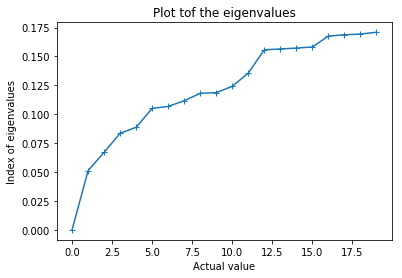

In [208]:
plt.plot(e[:20], '+-')
plt.xlabel('Actual value')
plt.ylabel('Index of eigenvalues')
plt.title('Plot tof the eigenvalues')

plt.show()

When using of spectral clustering as a mean to find communities, the plot above can help to find the number of communities. Indeed, what we call the "spectral gap" is supposed to indicate this number. It can be identified by a big gap in value between two successive eigenvalues.<br/>
Note that we can see such a gap only between the first two eigenvalues, suggesting that indeed there are only 2 communities. So it seems that via spectral clustering, it is not possible to recover the continents.

A reason why it is the case is that spectral clustering works well when there are **clear** clusters, which is not the case there. Even though there can be many connections within a continent, it can happen that there are also many edges between two continents (think of America and Europe for example).

Is it still possible to find communities in our network corresponding to the continents via other methods?


## Finding communities by modularity maximization

Another popular way for detecting communities in a graph is by maximizing a quantity called ***modularity***. Modularity is a measure of the quality of a particular partition of a network into communities. The higher the modularity, the better the partition is. Indeed, networks with high modularity have many edges between nodes in the same community but very few edges between nodes in different communities.

So a natural way to find a good partition is simply to find one which has the maximum modularity, between all possible partitions. This is of course not possible, because of time complexity reasons, and so we present algorithms such as ***Greedy Modularity Maximization***, that aim to find the a partition of the graph into communities such that the modularity is particularly high.

We will also review the ***Louvain Method***, which also aim to maximize the modularity, and turns out to be a lot more efficient than the regular greedy approach.

### Greedy Modularity Maximization

We first use the Greedy Modularity Maximization, also called CNM algorithm:

In [91]:
 c2 = nx.algorithms.community.greedy_modularity_communities(largest_cc)

We then plot on the world map the first 5 communities found by the algorithm, hoping that they will represent the continents. The other nodes are just displayed in gray:

In [102]:
size = 5
cmap = plt.cm.get_cmap('gist_rainbow')
rgba = np.linspace(0.0, 1.0, num=size)
list_col=[]

for node in largest_cc.nodes:
    curr_len = len(list_col)
    for i in range(size):
        if node in c2[i]:
            list_col.append(cmap(rgba[i]))
            
    if len(list_col) == curr_len:
        list_col.append((0.5, 0.5, 0.5))

/home/adirlou/.local/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


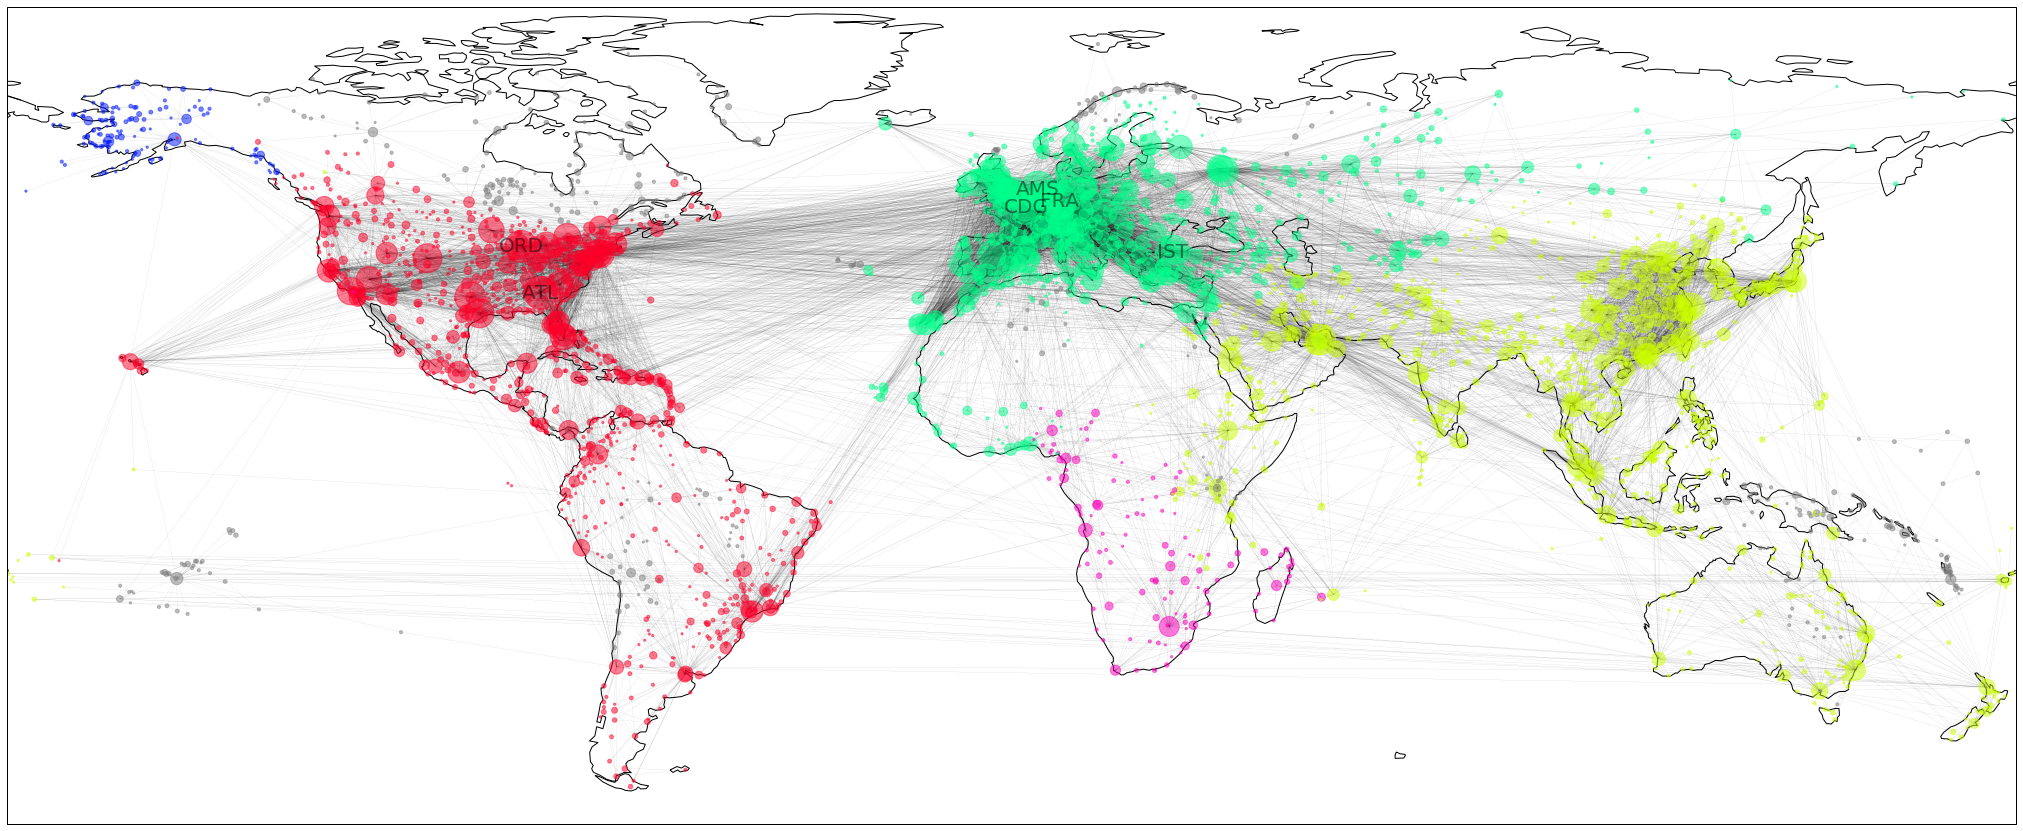

In [103]:
display_map(largest_cc, node_color=list_col)

Much better! It seems that by using the modularity, we can get better results. We see for example that Europe, America and Asia with Oceania are detected as communities. So this means that for each of these, there are way more connections inside them, compared to the number connections that leads outside of them.

## Louvain

In [9]:
def plot_community_distr(G):
    
    partition1 = nx.algorithms.community.greedy_modularity_communities(G)
    partition2 = community.best_partition(G)
    
    # Partition1
    mod_classes = np.arange(len(partition1))

    # Partition2
    c = collections.Counter(list(partition2.values()))
    k = c.keys()
    v = c.values()
    
    num_nodes = []
    for set_ in partition1:
        num_nodes.append(len(set_))
    
    plt.figure(figsize=(15,9))
    plt.scatter(mod_classes, num_nodes, label='Clauset-Newman-Moore greedy modularity maximization')
    plt.scatter(k, v, label='Louvain method')
    plt.axis([0, 41, 0, 950])
    plt.xlabel('Modularity class')
    plt.ylabel('Number of nodes')
    plt.xticks(mod_classes)
    plt.legend()
    plt.grid()

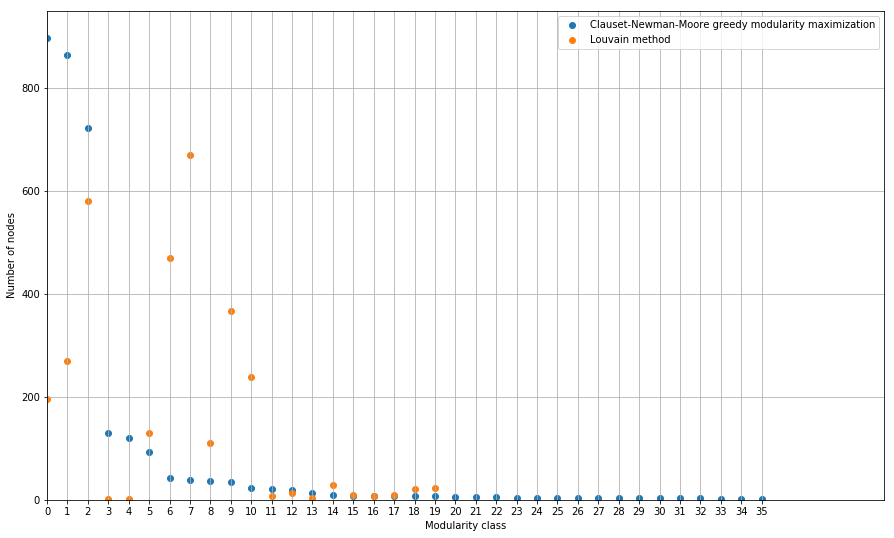

In [10]:
plot_community_distr(largest_cc)

In [156]:
#first compute the best partition
partition = community.best_partition(largest_cc)

#drawing
size = len(set(partition.values()))

cmap = plt.cm.get_cmap('gist_rainbow')
rgba = np.linspace(0.0, 1.0, num=size)
    
list_color = []
for n in largest_cc.nodes:
    list_color.append(cmap(rgba[partition[n]]))


/home/adirlou/.local/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


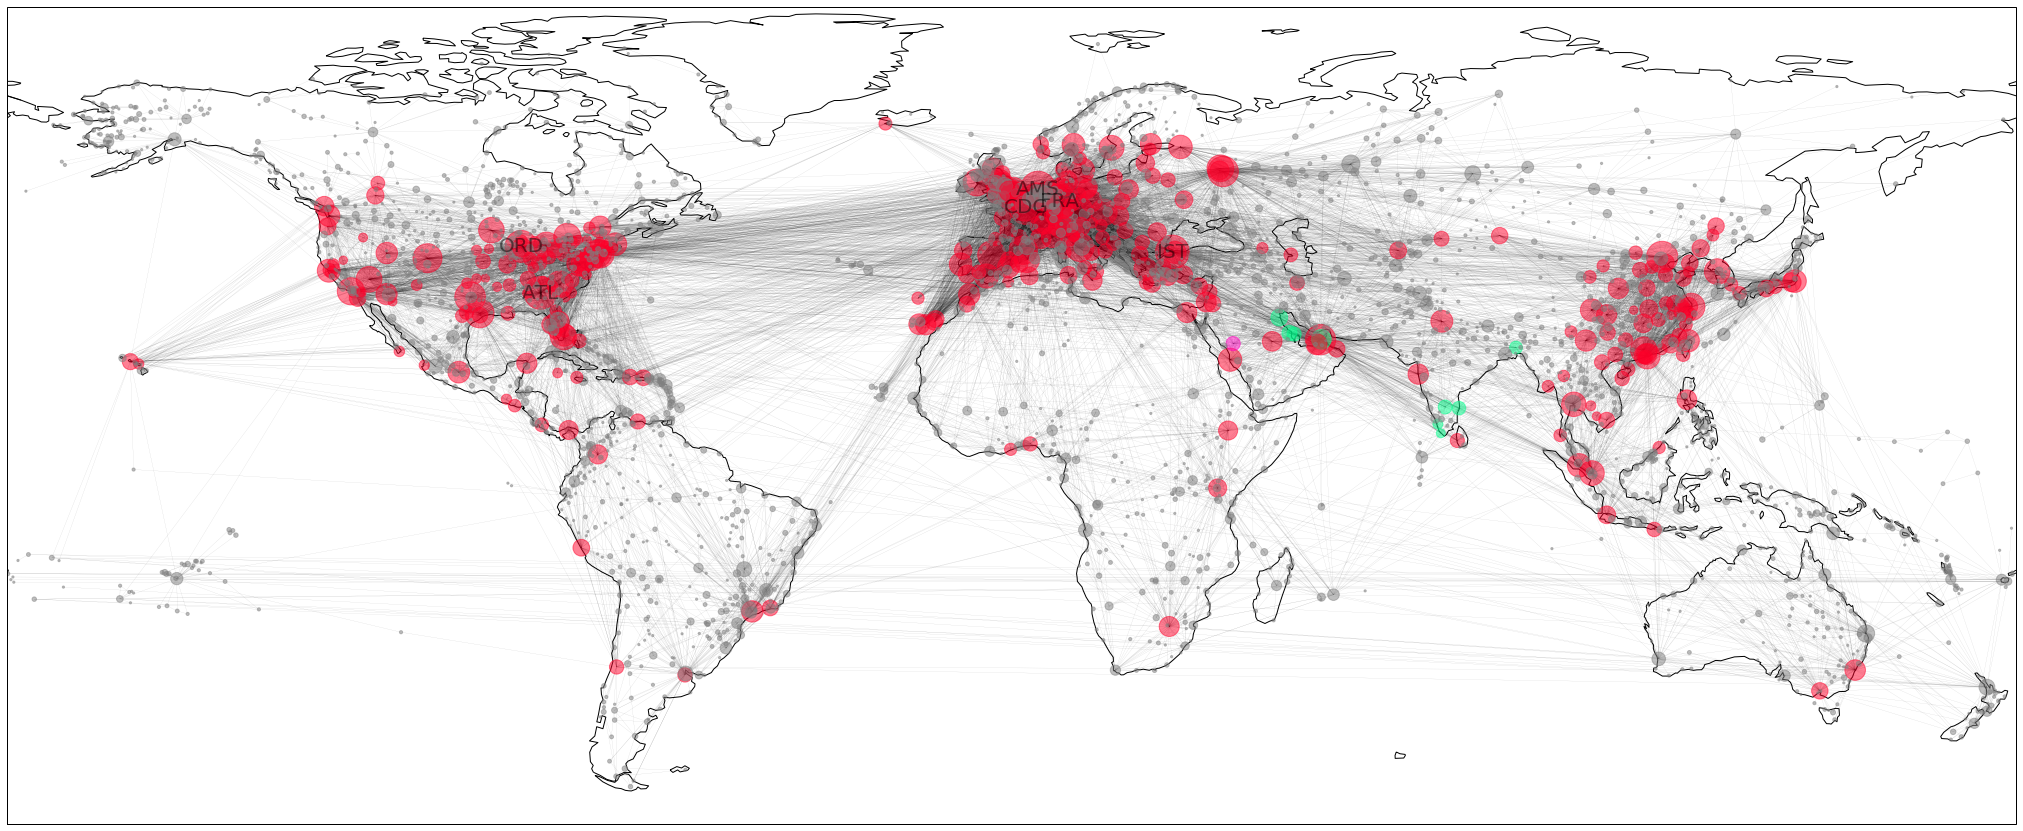

In [157]:
display_map(largest_cc, node_color=list_col)

## Girvan-Newman

In [ ]:
graph = largest_cc.copy()
#Arbitrary number of communities : needs to be big since a lot of very small communities are created in the process
wanted_communities = 34
communities = 1 #Initialization of parameters
subgraphs = [(graph, len(graph))]

In [ ]:
while communities != wanted_communities:
    #We made the assumption that we always want to divide the biggest existing community
    to_divide = subgraphs[0][0]
    subgraphs.pop(0)
    #To follow computation
    print('Communities : ', communities)
    edges_removed = 0
    while nx.is_connected(to_divide):
        
        #Remove 15% of edges at random
        edges = list(to_divide.edges)
        random.shuffle(edges)
        to_remove = edges[:int(0.15*len(edges))]
        to_divide.remove_edges_from(to_remove)
        
        #Computing edge betweenness to find edge to remove
        centrality = nx.edge_betweenness_centrality(to_divide)
        sorted_centrality = sorted(centrality.items(), key=operator.itemgetter(1), reverse=True)
        to_divide.remove_edge(sorted_centrality[0][0][0], sorted_centrality[0][0][1])
        edges_removed +=1
        print('Edges_removed : ', edges_removed)
        
        #Adding the previously removed edge for next iteration
        to_divide.add_edges_from(to_remove)
        
    subgraph = nx.connected_component_subgraphs(to_divide)#We now have divided a graph in 2 subgraphs
    for _iter in range(2):
        sub = next(subgraph)
        subgraphs.append((sub, len(sub)))
    subgraphs = sorted(subgraphs, key=lambda tup: tup[1], reverse=True)#Sorting in order to divide the biggest graph on next iteration
    communities=len(subgraphs)

In [ ]:
#Long computation, might want to save results
np.save("subgraphs", subgraphs)

In [ ]:
#Picking distinguishable colors for biggest communities
colors = []
for node in largest_cc.nodes:
    cluster = 0
    while (not node in subgraphs[cluster][0]) & (cluster < 8):
        cluster +=1
    if cluster == 0:
        colors.append('tab:red')
    if cluster == 1:
        colors.append('tab:blue')
    if cluster == 2:
        colors.append('tab:green')
    if cluster == 3:
        colors.append('tab:orange')
    if cluster == 4:
        colors.append('tab:cyan')
    if cluster == 5:
        colors.append('tab:brown')
    if cluster == 6:
        colors.append('tab:olive')
    if cluster == 7:
        colors.append('tab:purple')
    if cluster == 8:#All the other communities
        colors.append('tab:gray')

In [ ]:
fig, ax = plt.subplots(
    1, 1, figsize=(36, 24),
    subplot_kw=dict(projection=ccrs.PlateCarree()))
ax.coastlines()

nx.draw_networkx(largest_cc, ax=ax,
                 font_size=20,
                 alpha=.5,
                 width=.075,
                 node_size=sizes,
                 labels=labels,
                 pos=pos,
                node_color=colors)